# Class 4 - Bias-variance trade-off and Decision Trees
Yesterday, we introduce the notions of bias and variance, which quantify two dimensions of error in predictive modeling. We saw that:
- *Bias* is the distance between the average of predictions made by a given model when trained on different training sets and the predictions made by the true model;
- *Variance* is the variance of predictions made by a given model when trained on different training sets.

Importantly, bias and variance are modulated by the complexity or flexibility of a model in different ways. As complexity/flexibility increases, bias tends to decrease, while variance increases.

This is why we talk about a _bias-variance trade-off_: ideally, we want to minimize both sources of prediction error, but in practice, modeling decisions that lead to lower bias will also lead to higher variance (and viceversa).
What we want to do when designing our model is to hit the optimal balance between bias and variance.

Alongside this, we introduced **decision trees** as an additional modeling algorithm for both regression and classification.
Decision trees are implemented in `scikit-learn`. You can check out this link for a brush-up of what they are with some examples: https://scikit-learn.org/stable/modules/tree.html. 
Classes for regression (`DecisionTreeRegressor`) and classification (`DecisionTreeClassifier`) are documented respectively at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html and https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html. 
We have discussed hyperparameters of decision trees that influence its complexity and flexibility (e.g., tree depth, minimum number of total samples per leaf), and discussed why flexibility matters for learning good decision trees.

In this exercise, we will take a break from our attempt to model bike data (fear not, we will resume next week and combine all we have learned so far with tree-based bagging and boosting methods, which we will introduce next week).
Our goal for today is see some of the notions we have introduced theoretically during our lecture in action, to get a better grasp of these complex notions.
We will look at a practical example of how bias and variance are modulated by model flexibility, using a linear model and decision trees as a test case.

### Today's plan
**Step 1** - Generating Data:
1. Generate 1000 data points from a uniform distribution, using `numpy.random.uniform` (https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html). Set the minimum value to -10 and the maximum value to 10. This will be your $x$.
2. Generate polynomial terms for x, using `sklearn.preprocessing.PolynomialFeatures` (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
3. Generate 4 random coefficients $\beta_{i}$ from a uniform distribution (same parameters as above)
4. Generate an outcome variable using the following equation: $y = \beta_{0} + \beta_{1} * x + \beta_{2} * x^2 + \beta_{3} * x^3 $. To do so, you might find 
5. Add some Gaussian noise to your $y$ using `np.random.normal` (set the `scale` parameter to 10 to make this noise "visible", see https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
6. Plot the relation between $x$ and $y$
7. Finally, split your data into two halves, a training and a test set, using sklearn's `train_test_split`

**Step 2** - Compute squared bias and variance of linear models with increasing complexity:
1. Compute average **squared bias**, **variance**, and **MSE** for a linear model that only uses *x* as input feature.
    - To do so, you need to create a loop where you take random samples of the training data (1/2 the size of the training set), say, 100 times. This process is called **bootstrapping**.
    - For each random split of the data:
        - You fit a `LinearRegression` estimator on the sampled data
        - You predict $\hat{y}$ for all test data points
        - You compute the average **squared** bias across all data points in the test set. To do so you need to:
            1. Compute the average prediction of your bootstrapped models for each data point
            2. Compute the difference between these values and the predictions of the true model for each data point
            3. Take the squared value of that
            4. Average across all data points
            5. NOTE: we look at the average *squared* bias, because the bias of a single data point encodes information about the *directionality* of the error. If we averaged those values, we will underestimate models' tendency to make systematic errors.
        - You compute the average variance of the predictions of bootstrapped models across all data points in the test set
        - You compute the average MSE of your method (computing the average of MSEs of each bootstrapped model)
2. Now that you know how to compute this, scale this up. Fit linear regressions with input features that include increasingly high polynomial expansions of your feature set (first only $x, x^2$, then $x, x^2, x^3$ and all the way up to $x,...,x^{10}$)
3. Make a plot where you show how bias, variance and MSE change as a function of model complexity (i.e., how many polynomials you include)
4. Look at the patterns emerging from the plot and discuss them with your group: what do you notice?

**Bonus tasks**:
- We have talked about decision trees in the lecture. Can you do minimal changes to the code above, to look at how bias and variance change as a function of the expected depth of a tree, or additional parameters related to the complexity of a decision tree? Use `DecisionTreeRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) as an extractor, and loop over multiple values of `max_depth` (e.g., ranging from 1 to 20)
- How do your results change as you manipulate parameters such as the the true generative model (e.g., its complexity), the size of bootstrapped data samples, etc?


### Solutions
As usual, you will find a solution in `example.ipynb`

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

## 1. data generation

In [2]:
# Generate 1000 random x values
x = np.random.uniform(low=-10, high=10, size=(1000,1))

In [3]:
# Generate polynomial terms - to a degree of 3
X = PolynomialFeatures(degree=3).fit_transform(x)

In [15]:
X.shape

(1000, 4)

Now X is a twodimensional array AKA matrix with 1000 rows and 4 features

In [4]:
# Generate random coefficients
coefs = np.random.uniform(low=-10, high=10, size=(1,4))

In [22]:
coefs

array([[ 2.90395784,  6.71720341,  9.46815624, -4.83862472]])

In [5]:
y = X*coefs # multiply the values in the 4 coulumns with the coefficient for that column (or polynomial term)
y = np.sum(y, axis=1) # sum to get y (y = b*x0 + b*x1 ...), axis 1 to sum over the four columns

# Adding noise
y = y + np.random.normal(0, 100, size=y.shape)

In [6]:
# Could have been done in one line
y = np.sum(X * coefs + np.random.normal(0, 100, size=X.shape), axis=1)

In [32]:
y.shape

(1000,)

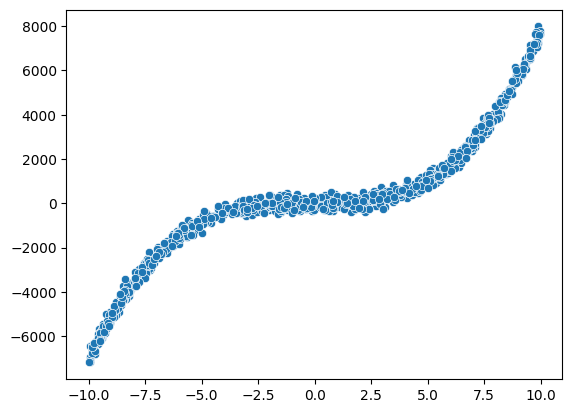

In [7]:
# Plot relation
sns.scatterplot(x=x[:,0], y=y) # lille x! [:,0] for at få values ud - se hvordan x er struktureret som array[[...]]
plt.show()

In [8]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.5)

In [9]:
# making true predictions
y_pred_true = np.sum(X_test*coefs, axis=1)

## 2. Bias and variance computation

In [10]:
# function for computing squared bias 
def _compute_bias(pred, true): 

    mpred = pred.mean(axis = 1) # average predictions for each row across bootstraps

    return (((true - mpred)**2)).mean() # squaring the difference between true and predicted and returning the average


In [11]:
# function for computing variance
def _compute_variance(pred): # _ for at indikere at functionen KUN bliver brugt som hjælpefunction inden i en anden funktion

    return pred.var(axis = 1).mean() # finding the variance of the predictions across bootstraps returning an average of these

In [1]:
# loading performances from last
perf_df = pd.read_csv("/work/SilleHasselbalchMarkussen#4503/DataSci-AU-24/nbs/group_RMDS/log/performances.csv", index_col=0)
performances = perf_df.to_dict(orient='records')

NameError: name 'pd' is not defined

In [17]:
n_sim = 100 # this defines how many times we do bootstrapping
pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps


reg = LinearRegression() # initialize the model 
transformer = PolynomialFeatures(degree=3)

# bootstrapping
for sim in range(n_sim): # bootstrap n_sim times
    x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data - _ are used as place holders
    x_fit = transformer.fit_transform(x[:,1].reshape(-1,1)) # take x, and add all polynomials all the way to c (current complexity)
    x_test = transformer.fit_transform(X_test[:,1].reshape(-1,1)) # do the same with the test set
    reg.fit(x_fit,y) # fit the model
    preds = reg.predict(x_test) # predict the outcomes
    pred_all[:,sim] = preds # store that in the big result matrix


# once we are done bootstrapping, we have predictions for all models
mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                            pred_all[:,sim])) # compute the average MSE of the models
                for sim in range(n_sim)]) # list comprehension - doing this for all bootstraps


# computing performance
bias = _compute_bias(pred_all, y_pred_true) # get bias - y_pred_true from cell above
variance = _compute_variance(pred_all) # get variance
info = ('linear', bias, variance, mse)
performances.append(info) # append model info to performances

# Getting the results into a dataframe 
outputs = ['mtype', # this is the information we want to store in the DF
           'bias^2', 
           'variance', 
           'mse']
result = pd.DataFrame(performances, columns=outputs)

In [18]:
result

,mtype,bias^2,variance,mse
0,linear,135.043217,327.687215,201.137362


#### Scaled up - varying complexity (Roberta's code)

In [ ]:
max_degree = 10 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 1000 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance', 
           'mse']

for c in range(1, max_degree):
    reg = LinearRegression() # initialize the model 
    pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    for sim in range(n_sim): # bootstrap n_sim times
        x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data
        transformer = PolynomialFeatures(degree=c)
        x_fit = transformer.fit_transform(x[:,1].reshape(-1,1)) # take x, and add all polynomials all the way to c (current complexity)
        x_test = transformer.fit_transform(X_test[:,1].reshape(-1,1)) # do the same with the test set
        reg.fit(x_fit,y) # fit the model
        preds = reg.predict(x_test) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix

    # once we are done bootstrapping, we have predictions for all models
    mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                              pred_all[:,sim])) # compute the average MSE of the models
                    for sim in range(n_sim)])
    bias = _compute_bias(pred_all, y_pred_true) # get bias
    variance = _compute_variance(pred_all) # get variance
    info = ('linear', x_fit.shape[1]-1, bias, variance, mse)
    performances.append(info) # append model info to performances

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance', 'mse']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)
performances = []